In [425]:
# preamble - load all packages 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
import plotly.express as px 

import tensorflow_probability as tfp

# import specific tools 
from sklearn.metrics.pairwise import euclidean_distances
from scipy import stats

sns.set()

# Population Level Models 

*based on simulated data*


In [426]:
def sir1(beta, gamma, S0, I0, R0):
    # initial values
    S = S0
    I = I0
    R = R0
    N = S0 + I0 + R0
    t = 0

    # keep track of time epidemic state
    accum = [(t, S, I, R)]

    # simulate until epidemic ends
    while True:

        # 1. calculate rates
        si_rate = beta * S * I 
        ir_rate = gamma * I
        total_rate = si_rate + ir_rate

        # exit condition
        if total_rate == 0.0:
            break

        # 2. sample next event (event is a transition from S -> I or I -> R)
        tstar = np.random.exponential(1 / total_rate)

        t += tstar

        # 3. sample type of even (here we choose between S -> I or I -> R - exclusive
        if np.random.uniform() < si_rate / total_rate:
            S -= 1
            I += 1
            R = R  # add 0
        else:
            S = S  # add 0
            I -= 1
            R += 1

        # 4. Keep track of progress
        accum.append((t, S, I, R))

    # format for output
    results = np.array(accum)
    return dict(t=results[:, 0],
                S=results[:, 1],
                I=results[:, 2],
                R=results[:, 3])

In [456]:
epi = pd.DataFrame(sir1(beta=0.3, gamma=0.01, S0=999, I0=1, R0=0))

In [457]:
epi.tail()

,t,S,I,R
1995,632.988423,0.0,4.0,996.0
1996,647.781062,0.0,3.0,997.0
1997,660.157869,0.0,2.0,998.0
1998,698.258050,0.0,1.0,999.0
1999,798.799532,0.0,0.0,1000.0


<AxesSubplot:>

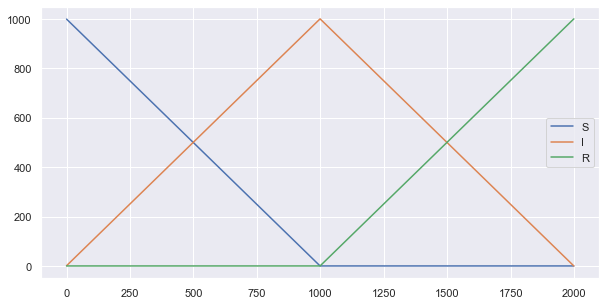

In [458]:
epi.loc[:,'S':'R'].plot(figsize = (10,5))

From the above function we can see that the data is generated from an exponential distribution. Specifically, the infectious times come from an exponential distribution with rate $\beta$ and the removals from an exponential distribution with rate $\gamma$. Further, our data tells us the times of infections (denote them $I = \{i_1,\ldots, i_m\}$) and the removal times (denote $R = \{ r_1, \ldots, r_m\})$

\begin{align}
&\prod_{j=1}^m \beta I(i_j)R(i_j) \exp \{ - \sum_{k=1}^m \beta I(i_j)R(i_j) \triangle t \} \\
&\prod_{j=1}^n \gamma R(r_j) \exp \{ - \sum_{k=1}^n \gamma R(r_j) \triangle t \} \\
\Rightarrow  L(I,R|\beta, \gamma) &=  \prod_{j=1}^m \beta I(i_j)R(i_j) \prod_{j=1}^n \gamma R(r_j) \exp \{ - \sum_{j=1}^T [ \beta I(i_j)R(i_j) + \gamma R(r_j) ] \triangle t_j \}
\end{align}

To make the products easier to deal with, we use the log-likelihood and get some additional simplifications. 

\begin{align}
l(I,R|\beta, \gamma) &= \sum_{j=2}^m \log [\beta I(i_j)R(i_j)] + \sum_{j=1}^n \log [\gamma R(r_j)] - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j \\
&=(m-1) \log \beta +  \sum_{j=2}^m \log [I(i_j)R(i_j)] + n \log \gamma  +\sum_{j=1}^n \log [ R(r_j)]  - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j \\
&\propto (m-1) \log \beta + n \log \gamma - \sum_{j=1}^T [\beta I(i_j)R(i_j) + \gamma R(r_j)]\triangle t_j
\end{align}
Where $m$ is the number of infection events, and $n$ is the number of removal events. 

In [430]:
# data augmentation
# 1. compute delta t's
# 2. compute infection identifier
# 3. compute removal identifier
epi_augment = epi.assign(delta_t=lambda df: df.t.diff(1),
                         infection_event=lambda df: df.I > df.I.shift(1),
                         removal_event=lambda df: df.R > df.R.shift(1))
epi_augment.tail()

,t,S,I,R,delta_t,infection_event,removal_event
1995,48.718486,0.0,4.0,996.0,1.441809,False,True
1996,56.152960,0.0,3.0,997.0,7.434474,False,True
1997,60.525428,0.0,2.0,998.0,4.372467,False,True
1998,61.587321,0.0,1.0,999.0,1.061893,False,True
1999,68.246582,0.0,0.0,1000.0,6.659261,False,True


In [431]:
# code the above function
def log_like(df, beta, gamma):
    return (df.infection_event.sum() - 1) * np.log(beta) + \
        df.removal_event.sum() * np.log(gamma) - \
        np.sum((beta * df.I * df.R + gamma * df.R)*df.delta_t)

In [432]:
# define the priors
def prior(beta, gamma):
    return stats.gamma.logpdf(gamma,a = 3, loc=0, scale=10) + stats.gamma.logpdf(beta, a = 3, loc=0, scale=10)

In [433]:
# define the proposal denisity for the MH algo
def proposal(beta, gamma):
    return stats.norm.rvs(loc=[beta, gamma], scale=0.01)

In [434]:
# run MH-MCMC algo
def metropolisHastings(starting_values, log_likelihood, prior_spec, proposal_density, data, iters=10000):
    # storing variables
    mat = np.zeros(shape=(iters, len(starting_values)))
    mat[0, ] = starting_values

    acceptances = [0]
    ll = log_likelihood(data, beta=mat[0, 0], gamma=mat[0, 1])

    # run the MH algo
    for ii in range(iters-1):
        # step 2: propose new step
        new_theta = proposal_density(beta=mat[ii, 0], gamma=mat[ii, 1])

        # step 3: compute acceptance prob
        ll_proposed = log_likelihood(
            data, beta=new_theta[0], gamma=new_theta[1])

        alpha = (ll_proposed - ll) + \
            (prior_spec(new_theta[0], new_theta[1]) -
             prior_spec(beta=mat[ii, 0], gamma=mat[ii, 1]))
        # step 4: accept/reject
        if (alpha > np.log(stats.uniform(0, 1).rvs())):
            mat[ii+1, ] = new_theta
            ll = ll_proposed
            acceptances.append(1)
        else:
            mat[ii+1, ] = mat[ii, ]
            acceptances.append(0)

    return mat, acceptances

In [435]:
output, accept = metropolisHastings(starting_values=[0.1, 0.1],
                                    log_likelihood=log_like,
                                    prior_spec=prior,
                                    proposal_density=proposal,
                                    data=epi_augment,
                                    iters=10001)

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_3450/1921211778.py:3: RuntimeWarning: invalid value encountered in log
  return (df.infection_event.sum() - 1) * np.log(beta) + \
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_3450/1921211778.py:4: RuntimeWarning: invalid value encountered in log
  df.removal_event.sum() * np.log(gamma) - \


array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

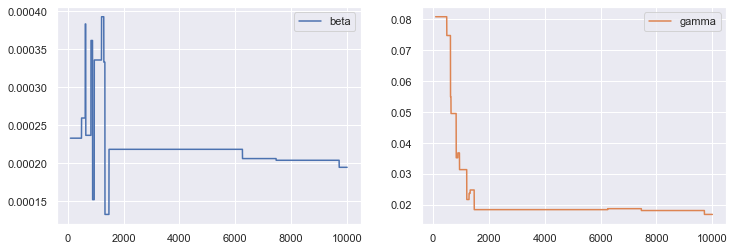

In [436]:
pd.DataFrame(output, columns=['beta', 'gamma']).loc[100:, ].plot(
    figsize=(12, 4), subplots=True, layout=(1, 2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

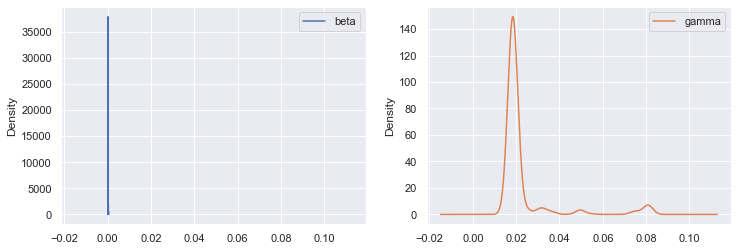

In [437]:
pd.DataFrame(output, columns=['beta', 'gamma']).loc[100:, ].plot(
    kind = 'kde',figsize=(12, 4), subplots=True, layout=(1, 2))

In [438]:
pd.DataFrame(output, columns=['beta','gamma']).loc[100:,].describe()

,beta,gamma
count,9901.000000,9901.000000
mean,0.000219,0.023056
std,0.000033,0.014399
min,0.000133,0.016989
25%,0.000204,0.018246
50%,0.000218,0.018534
75%,0.000218,0.018845
max,0.000393,0.080859


In [439]:
np.sum(accept)/len(accept)

0.0029997000299970002

# Individual Level Models 

In [440]:
measles = pd.read_csv('measles_hagelloch_1861.csv')

In [441]:
measles.head()

,case_ID,infector,date_of_prodrome,date_of_rash,date_of_death,age,gender,family_ID,class,complications,x_loc,y_loc
0,1,45.0,1861-11-21,1861-11-25,NaN,7,f,41,1,yes,142.5,100.0
1,2,45.0,1861-11-23,1861-11-27,NaN,6,f,41,1,yes,142.5,100.0
2,3,172.0,1861-11-28,1861-12-02,NaN,4,f,41,0,yes,142.5,100.0
3,4,180.0,1861-11-27,1861-11-28,NaN,13,m,61,2,yes,165.0,102.5
4,5,45.0,1861-11-22,1861-11-27,NaN,8,f,42,1,yes,145.0,120.0


In [442]:
measles.shape

(188, 12)

In [443]:
pairwise_distances = euclidean_distances(X=measles[['x_loc', 'y_loc']])

In [444]:
measles['date_of_prodrome'] = pd.to_datetime(measles['date_of_prodrome'], format='%Y-%m-%d')
measles['date_of_rash'] = pd.to_datetime(measles['date_of_rash'], format='%Y-%m-%d')
measles['date_of_death'] = pd.to_datetime(measles['date_of_death'], format='%Y-%m-%d')

In [445]:
measles['date_of_death'] = measles['date_of_death'].fillna(pd.to_datetime('1/1/2000'))

In [446]:
measles.head()

,case_ID,infector,date_of_prodrome,date_of_rash,date_of_death,age,gender,family_ID,class,complications,x_loc,y_loc
0,1,45.0,1861-11-21,1861-11-25,2000-01-01,7,f,41,1,yes,142.5,100.0
1,2,45.0,1861-11-23,1861-11-27,2000-01-01,6,f,41,1,yes,142.5,100.0
2,3,172.0,1861-11-28,1861-12-02,2000-01-01,4,f,41,0,yes,142.5,100.0
3,4,180.0,1861-11-27,1861-11-28,2000-01-01,13,m,61,2,yes,165.0,102.5
4,5,45.0,1861-11-22,1861-11-27,2000-01-01,8,f,42,1,yes,145.0,120.0


## Data augmentation 

The above dataset is a complete epidemic dataset since the dates for each individuals transition through the S-I-R model are recorded. With the model propsed by Neal & Roberts, some data augmentation is needed. The full likelihood of the model is as follows: 

$$f(I,R | \beta, \theta, Z, P, I_k) = \prod_{j \neq k} \left\{ \sum_{i \in I_j} \beta \exp \{ -\theta \kappa(i,j) \} \right\} \exp \left\{ \sum_{j=1}^m \sum_{k=1}^n \lambda_{jk} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} \right\} \prod_{i=1}^m g(S_i - I_i) $$ 

\begin{equation}
    \log f(I,R | \beta, \theta, Z, P, I_k) = \sum_{j \neq k} \log \left( \sum_{i:I_i \leq I_j \leq R_i } \lambda_{ij}(I_j) \right) - \sum_{j=1}^m \sum_{k=1}^n \lambda_{jk} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} + \sum_{i=1}^m \log f(D_i|\delta)
\end{equation} 

In [447]:
# this is the matrix of min pairwise dates 
pairwise_infections = np.fmin(measles.date_of_prodrome[:,np.newaxis], measles.date_of_prodrome[np.newaxis,:])

pairwise_infection_recovery = np.fmin(measles.date_of_prodrome[:,np.newaxis], measles.date_of_death[np.newaxis,:])

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_3450/2838994450.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pairwise_infections = np.fmin(measles.date_of_prodrome[:,np.newaxis], measles.date_of_prodrome[np.newaxis,:])
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_3450/2838994450.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pairwise_infection_recovery = np.fmin(measles.date_of_prodrome[:,np.newaxis], measles.date_of_death[np.newaxis,:])


In [448]:
# create a matrix I_{ij} to show the overlapping infectivity 
measles.date_of_death.describe()

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_3450/1084514439.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  measles.date_of_death.describe()


count                     188
unique                      9
top       2000-01-01 00:00:00
freq                      176
first     1861-11-18 00:00:00
last      2000-01-01 00:00:00
Name: date_of_death, dtype: object